In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from src.dm import DataModule
from src.models.unet_df_temp import UNetDFT as Module

In [17]:
import torch 

checkpoint = 'checkpoints/dft-val_metric=31.86896-epoch=89.ckpt'

hparams = {
	'encoder': 'resnet18',
    'pretrained': 'imagenet',
    'in_channels_s1': 2,
    'in_channels_s2': 3,
    'seq_len': 12,
    'p': 0
}

# module = UNet.load_from_checkpoint(checkpoint)
# module.hparams

state_dict = torch.load(checkpoint)['state_dict']
module = Module(hparams)
module.load_state_dict(state_dict)

<All keys matched successfully>

In [36]:
dm = DataModule(val_size=0.2, num_workers=10, pin_memory=True)
dm.setup()

train: 6951
val: 1738
test: 2773


In [38]:
from tqdm import tqdm 
import numpy as np

dl = dm.val_dataloader()
module.cuda()
metrics = []
for batch in tqdm(dl):
    x, y = batch
    x = (x[0].cuda(), x[1].cuda())
    preds = module.predict(x)
    metrics.append(torch.mean(torch.sqrt(torch.mean((preds * 12905.3 - y.cuda() * 12905.3)**2, dim=(1, 2)))))

torch.mean(torch.tensor(metrics)).item()

100%|██████████| 55/55 [00:24<00:00,  2.22it/s]


31.982484817504883

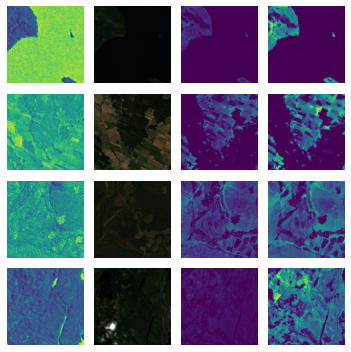

In [41]:
import torch 
import matplotlib.pyplot as plt 

dl = dm.val_dataloader(batch_size=4)
x, labels = next(iter(dl))
module.cpu()
preds = module.predict(x)
s1s, s2s = x

fig, ax = plt.subplots(4, 4, figsize=(5, 5))
for i in range(4):
	ax[i, 0].imshow(s1s[i][0][0])
	ax[i, 0].axis('off')
	ax[i, 1].imshow(s2s[i][0][:3,...].permute(1, 2, 0))
	ax[i, 1].axis('off')
	ax[i, 2].imshow(labels[i])
	ax[i, 2].axis('off')
	ax[i, 3].imshow(preds[i])
	ax[i, 3].axis('off')
plt.tight_layout()
plt.show()

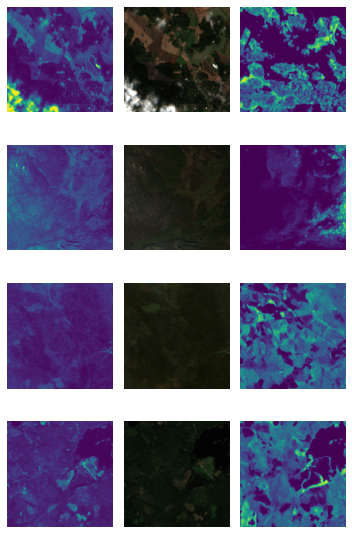

In [43]:
dl = dm.test_dataloader(batch_size=4)
x, _ = next(iter(dl))

module.cpu()
preds = module.predict(x)
s1s, s2s = x

fig, ax = plt.subplots(4, 3, figsize=(5, 8))
for i in range(4):
	ax[i, 0].imshow(s2s[i][0][0])
	ax[i, 0].axis('off')
	ax[i, 1].imshow(s2s[i][0][:3,...].permute(1, 2, 0))
	ax[i, 1].axis('off')
	ax[i, 2].imshow(preds[i])
	ax[i, 2].axis('off')
plt.tight_layout()
plt.show()

In [44]:
from tqdm import tqdm 
from skimage.io import imsave

dl = dm.test_dataloader(batch_size=16)

# si no tienes 2 gpus pon cuda(0)
module.cuda(1)

for x, chip_ids in tqdm(dl):
	x = (x[0].cuda(1), x[1].cuda(1))
	preds = module.predict(x)
	# preds = preds*(dm.ds_test.max - dm.ds_test.min) + dm.ds_test.min
	# preds = preds*dm.ds_test.std + dm.ds_test.mean
	preds = preds*dm.ds_test.max
	for chip_id, pred in zip(chip_ids, preds.cpu().numpy()):
		imsave(f'./submission/{chip_id}_agbm.tif', pred)

100%|██████████| 174/174 [00:45<00:00,  3.83it/s]


In [45]:
import glob 

files = glob.glob('./submission/*.tif')
assert len(files) == 2773

In [46]:
# zip folder 

import shutil
shutil.make_archive('submission', 'zip', './submission')

'/home/juan/Desktop/competis/TheBioMassters/submission.zip'

In [47]:
import rasterio as rio
import numpy as np

ix = np.random.randint(0, len(files))
ds = rio.open(files[ix])

ds.indexes, ds.shape, ds.count

/home/juan/miniconda3/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


((1,), (256, 256), 1)

In [48]:
x = ds.read(1)

x.shape, x.dtype, x.min(), x.max()

((256, 256), dtype('float32'), 0.0012664505, 229.16429)

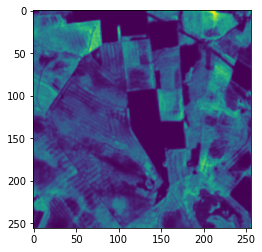

In [49]:
plt.imshow(x)
plt.show()